In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input,Conv2D,Conv2DTranspose,Reshape,Flatten,BatchNormalization,Activation,UpSampling2D,InputLayer
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [204]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


In [205]:
def adam_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

In [206]:
def create_generator():
    generator=Sequential()
   
    generator.add(Conv2D(64,(2,2),input_shape=(8,8,1)))

    generator.add(BatchNormalization())
    generator.add(LeakyReLU())


    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
 
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
 
 
    
    print(generator.output_shape)
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
   
    return generator

g=create_generator()
g.summary()

(None, 28, 28, 1)
Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_217 (Conv2D)         (None, 7, 7, 64)          320       
                                                                 
 batch_normalization_87 (Bat  (None, 7, 7, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_241 (LeakyReLU)  (None, 7, 7, 64)         0         
                                                                 
 conv2d_transpose_199 (Conv2  (None, 7, 7, 128)        204800    
 DTranspose)                                                     
                                                                 
 batch_normalization_88 (Bat  (None, 7, 7, 128)        512       
 chNormalization)                                                
                                  

In [207]:
def create_discriminator():
    discriminator=Sequential()
    
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same',input_shape=(28,28,1)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
   
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Flatten())
 
    discriminator.add(Dense(1, activation='sigmoid'))
    
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    
    return discriminator

d =create_discriminator()

d.summary()

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_218 (Conv2D)         (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_244 (LeakyReLU)  (None, 14, 14, 64)       0         
                                                                 
 conv2d_219 (Conv2D)         (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_245 (LeakyReLU)  (None, 7, 7, 128)        0         
                                                                 
 conv2d_220 (Conv2D)         (None, 4, 4, 64)          204864    
                                                                 
 leaky_re_lu_246 (LeakyReLU)  (None, 4, 4, 64)         0         
                                                                 
 flatten_36 (Flatten)        (None, 1024)           

In [208]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(8,8,1))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d,g)
gan.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 8, 8, 1)]         0         
                                                                 
 sequential_106 (Sequential)  (None, 28, 28, 1)        412544    
                                                                 
 sequential_107 (Sequential)  (None, 1)                412481    
                                                                 
Total params: 825,025
Trainable params: 412,032
Non-trainable params: 412,993
_________________________________________________________________


In [209]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 64])  
    noise=np.reshape(noise,(examples,8,8)) 
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.suptitle('Generated images after {} epochs'.format(str(epoch)), y=0.995)
    plt.tight_layout()    
    plt.savefig('gan_generated_image %d.png' %epoch)

In [210]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        for _ in range(batch_size):
            #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 64])
            noise=np.reshape(noise,(batch_size,8,8))
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)

            generated_images=np.reshape(generated_images,(batch_size,28,28))
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
          
            image_batch=np.reshape(image_batch,(batch_size,28,28))
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
           
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 64])
            noise=np.reshape(noise,(batch_size,8,8))
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        #For every 50 epochs, we plot the generated images
        if e % 50 == 0:
            plot_generated_images(e, generator)


(None, 28, 28, 1)
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


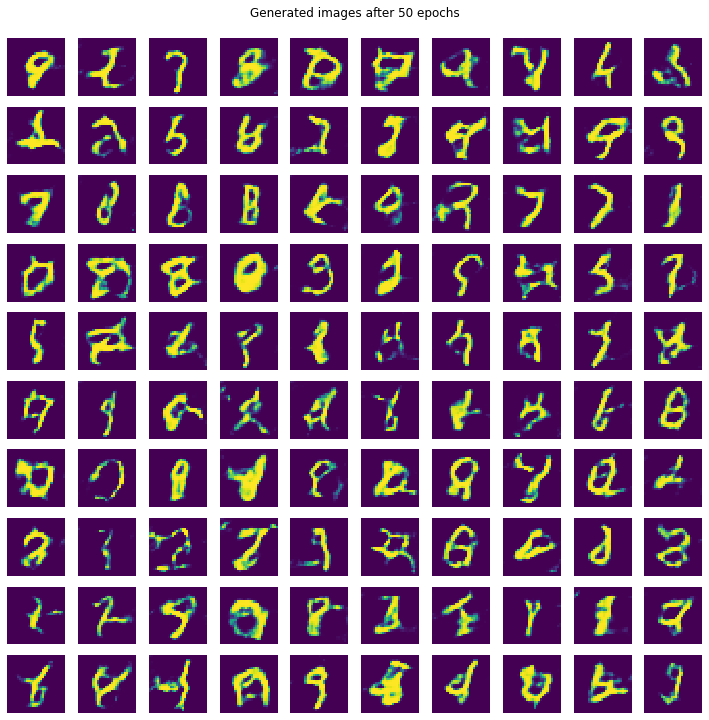

In [211]:
training(50,128)